In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import glob
import momlevel

In [3]:
outdir='/work/jet/data/interim/'

frq = 'annual'
#mods = ['CM4_historical_c192_OM4p125', 'CM4_historical_c192_OM4p25']
mods = ['CM4Xp125', 'CM4Xp25']
exps = ['piControl','historical','ssp585']
variables = ['ct', 'sa']
ddict = {mod:{} for mod in mods}
for i, mod in enumerate(ddict):
    ddict[mod] = {exp:{} for exp in exps}
    for j, exp in enumerate(exps):
        head = '%s_%s_c192_OM4%s'%(mod[:3],exp,mod[4:]) + ('_v8' if exp=='piControl' else '')
        for k, var in enumerate(variables):
            files = glob.glob(outdir+'%s_so_*_southof600S_asbw_%s_%s.nc'%(head, var, frq))
            if len(files)>1:
                print('WARNING: More than one file for '+mod)
            elif len(files)==0:
                print('ERROR: No files found for variable %s in %s'%(var,mod))
                ddict[mod][var] = []
                print('%s_so_*_southof600S_asbw_%s_%s.nc'%(head, var, frq))
                continue
                
            print('Loading '+files[0])
            ddict[mod][exp][var] =  xr.open_dataset(files[0])

Loading /work/jet/data/interim/CM4_piControl_c192_OM4p125_v8_so_0101to0270_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p125_v8_so_0101to0270_southof600S_asbw_sa_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_so_1850to2014_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_so_1850to2014_southof600S_asbw_sa_annual.nc
Loading /work/jet/data/interim/CM4_ssp585_c192_OM4p125_so_2015to2099_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_ssp585_c192_OM4p125_so_2015to2099_southof600S_asbw_sa_annual.nc
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p25_v8_so_0101to0360_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p25_v8_so_0101to0360_southof600S_asbw_sa_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_so_1850to2009_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_so_1850to2009_sout

In [4]:
def concatenate_datasets(historical, ssp585):
    # Identify static fields (not varying with time)
    static_vars = [var for var in historical.data_vars if 'time' not in historical[var].dims]

    # Separate static fields
    static_data = historical[static_vars]

    # Remove static fields from the datasets
    historical = historical.drop_vars(static_vars)
    ssp585 = ssp585.drop_vars(static_vars)

    # Concatenate along the time dimension
    concatenated = xr.concat([historical, ssp585], dim='time')

    # Add static fields back to the concatenated dataset
    for var in static_vars:
        concatenated[var] = static_data[var]

    return concatenated

In [5]:
# New dictionary for concatenated datasets
ddictc = {}
for mod in ddict:
    ddictc[mod] = {}
    for var in variables:
        ddictc[mod][var] = concatenate_datasets(ddict[mod]['historical'][var], ddict[mod]['ssp585'][var])

In [6]:
ds_ref = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data.nc',
                         decode_times=False, drop_variables=['depth'])
ds_ref = ds_ref.rename({'lon':'xh','lat':'yh'})
ds_ref['xh'].attrs['axis'] = 'X'
ds_ref['yh'].attrs['axis'] = 'Y'

# Create geolon/geolat
geolon, geolat = momlevel.util.tile_nominal_coords(ds_ref.xh, ds_ref.yh)
ds_ref['geolon'] = geolon
ds_ref['geolat'] = geolat

# Land mask
ds_ref['wet'] = xr.where(ds_ref.sa.isnull(),0.,1.).squeeze().rename('wet')

ddictc['Schmidtko'] = ds_ref

In [7]:
yr_st, yr_ed = '1975', '2012'

## Stats

In [1]:
import xcompare as xc
from om4labs.om4common import standard_grid_cell_area

AttributeError: module 'xarray.core' has no attribute 'resample'

In [ ]:
def horizontal_mean(varname, ds):
    num = (ds[varname] * ds['areacello'] * ds['wet']).sum(dim=['xh', 'yh'])
    denom = (ds['areacello'] * ds['wet']).sum(dim=['xh', 'yh'])
    return num / denom

In [ ]:
dset_ref = 'Schmidtko'

#yr_st, yr_ed = '1940', '1969'
ocean_coords = ['geolon', 'geolat', 'areacello', 'wet']
ds_ref = ddictc[dset_ref].reset_coords()

# Generate areacello
ds_ref['areacello'] = xr.DataArray(standard_grid_cell_area(ds_ref.yh, ds_ref.xh), dims=('yh', 'xh'), 
                                   coords={'yh': ds_ref.yh.values, 'xh': ds_ref.xh.values})

In [ ]:
var = 'ct'
horizontal_mean(var,ds_ref)

In [ ]:
ds_ref[var].weighted(ds_ref.areacello).mean()

In [9]:
da_ref = ds_ref[var]
da_ref['xh'].attrs['axis'] = 'X'
da_ref['yh'].attrs['axis'] = 'Y'
arr_ref = xc.coord_util.associate_ocean_coords(da_ref, ds_ref[ocean_coords], prefix=ocean_coords)

NameError: name 'xc' is not defined

In [23]:
from xcompare import xr_stats

In [16]:
stats = []
bias = []
rmse = []

for i, dset in enumerate(ddictc):
    print(dset)
    
    if dset==dset_ref:
        ds = ds_ref
        da = ddictc[dset][var]
        da['xh'].attrs['axis'] = 'X'
        da['yh'].attrs['axis'] = 'Y'
    else:
        ds = ddictc[dset][var]
        da = ds.sel(time=slice(yr_st, yr_ed)).mean('time')['bottom_'+var].rename(var)
    
    arr = xc.coord_util.associate_ocean_coords(da, ds[ocean_coords], prefix=ocean_coords)
    results = xc.compare_datasets(arr.to_dataset(), arr_ref.to_dataset(), varlist=[var])
    stats.append(xr_stats.xr_stats_2d(results['ds1'][var], results['ds2'][var], results['diff'].area, fmt='dict'))
    
    # calculate difference of arrays
    diff = results['ds2'][var] - results['ds1'][var]
    
    # calculate area-weighted bias
    bias.append(diff.weighted(results['diff'].area).mean())
    
    # rmse
    rse = np.sqrt(diff ** 2)
    rmse.append(rse.weighted(results['diff'].area).mean())

CM4Xp125
CM4Xp25
Schmidtko


In [17]:
import pandas as pd

In [18]:
pd.DataFrame(stats)

bias      rmse  rsquared
0  0.219688  0.467993  0.844033
1 -0.037567  0.472720  0.777833
2  0.000000  0.000000  1.000000

In [19]:
xr.concat(bias,pd.Index(list(ddictc), name='dset')).to_dataframe(name='bias')

bias
dset               
CM4Xp125  -0.219687
CM4Xp25    0.037567
Schmidtko  0.000000

In [20]:
xr.concat(rmse,pd.Index(list(ddictc), name='dset')).to_dataframe(name='rmse')

rmse
dset               
CM4Xp125   0.467993
CM4Xp25    0.472719
Schmidtko  0.000000

## Maps

In [8]:
import cmocean.cm as cmo
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [9]:
from mplsettings import setup_plots
setup_plots()

In [10]:
titstr = ['CM4X-p125 hist', 'CM4X-p25 hist', 'Schmidtko']

CM4Xp125 ct
CM4Xp125 sa
CM4Xp25 ct
CM4Xp25 sa
Schmidtko ct
Schmidtko sa


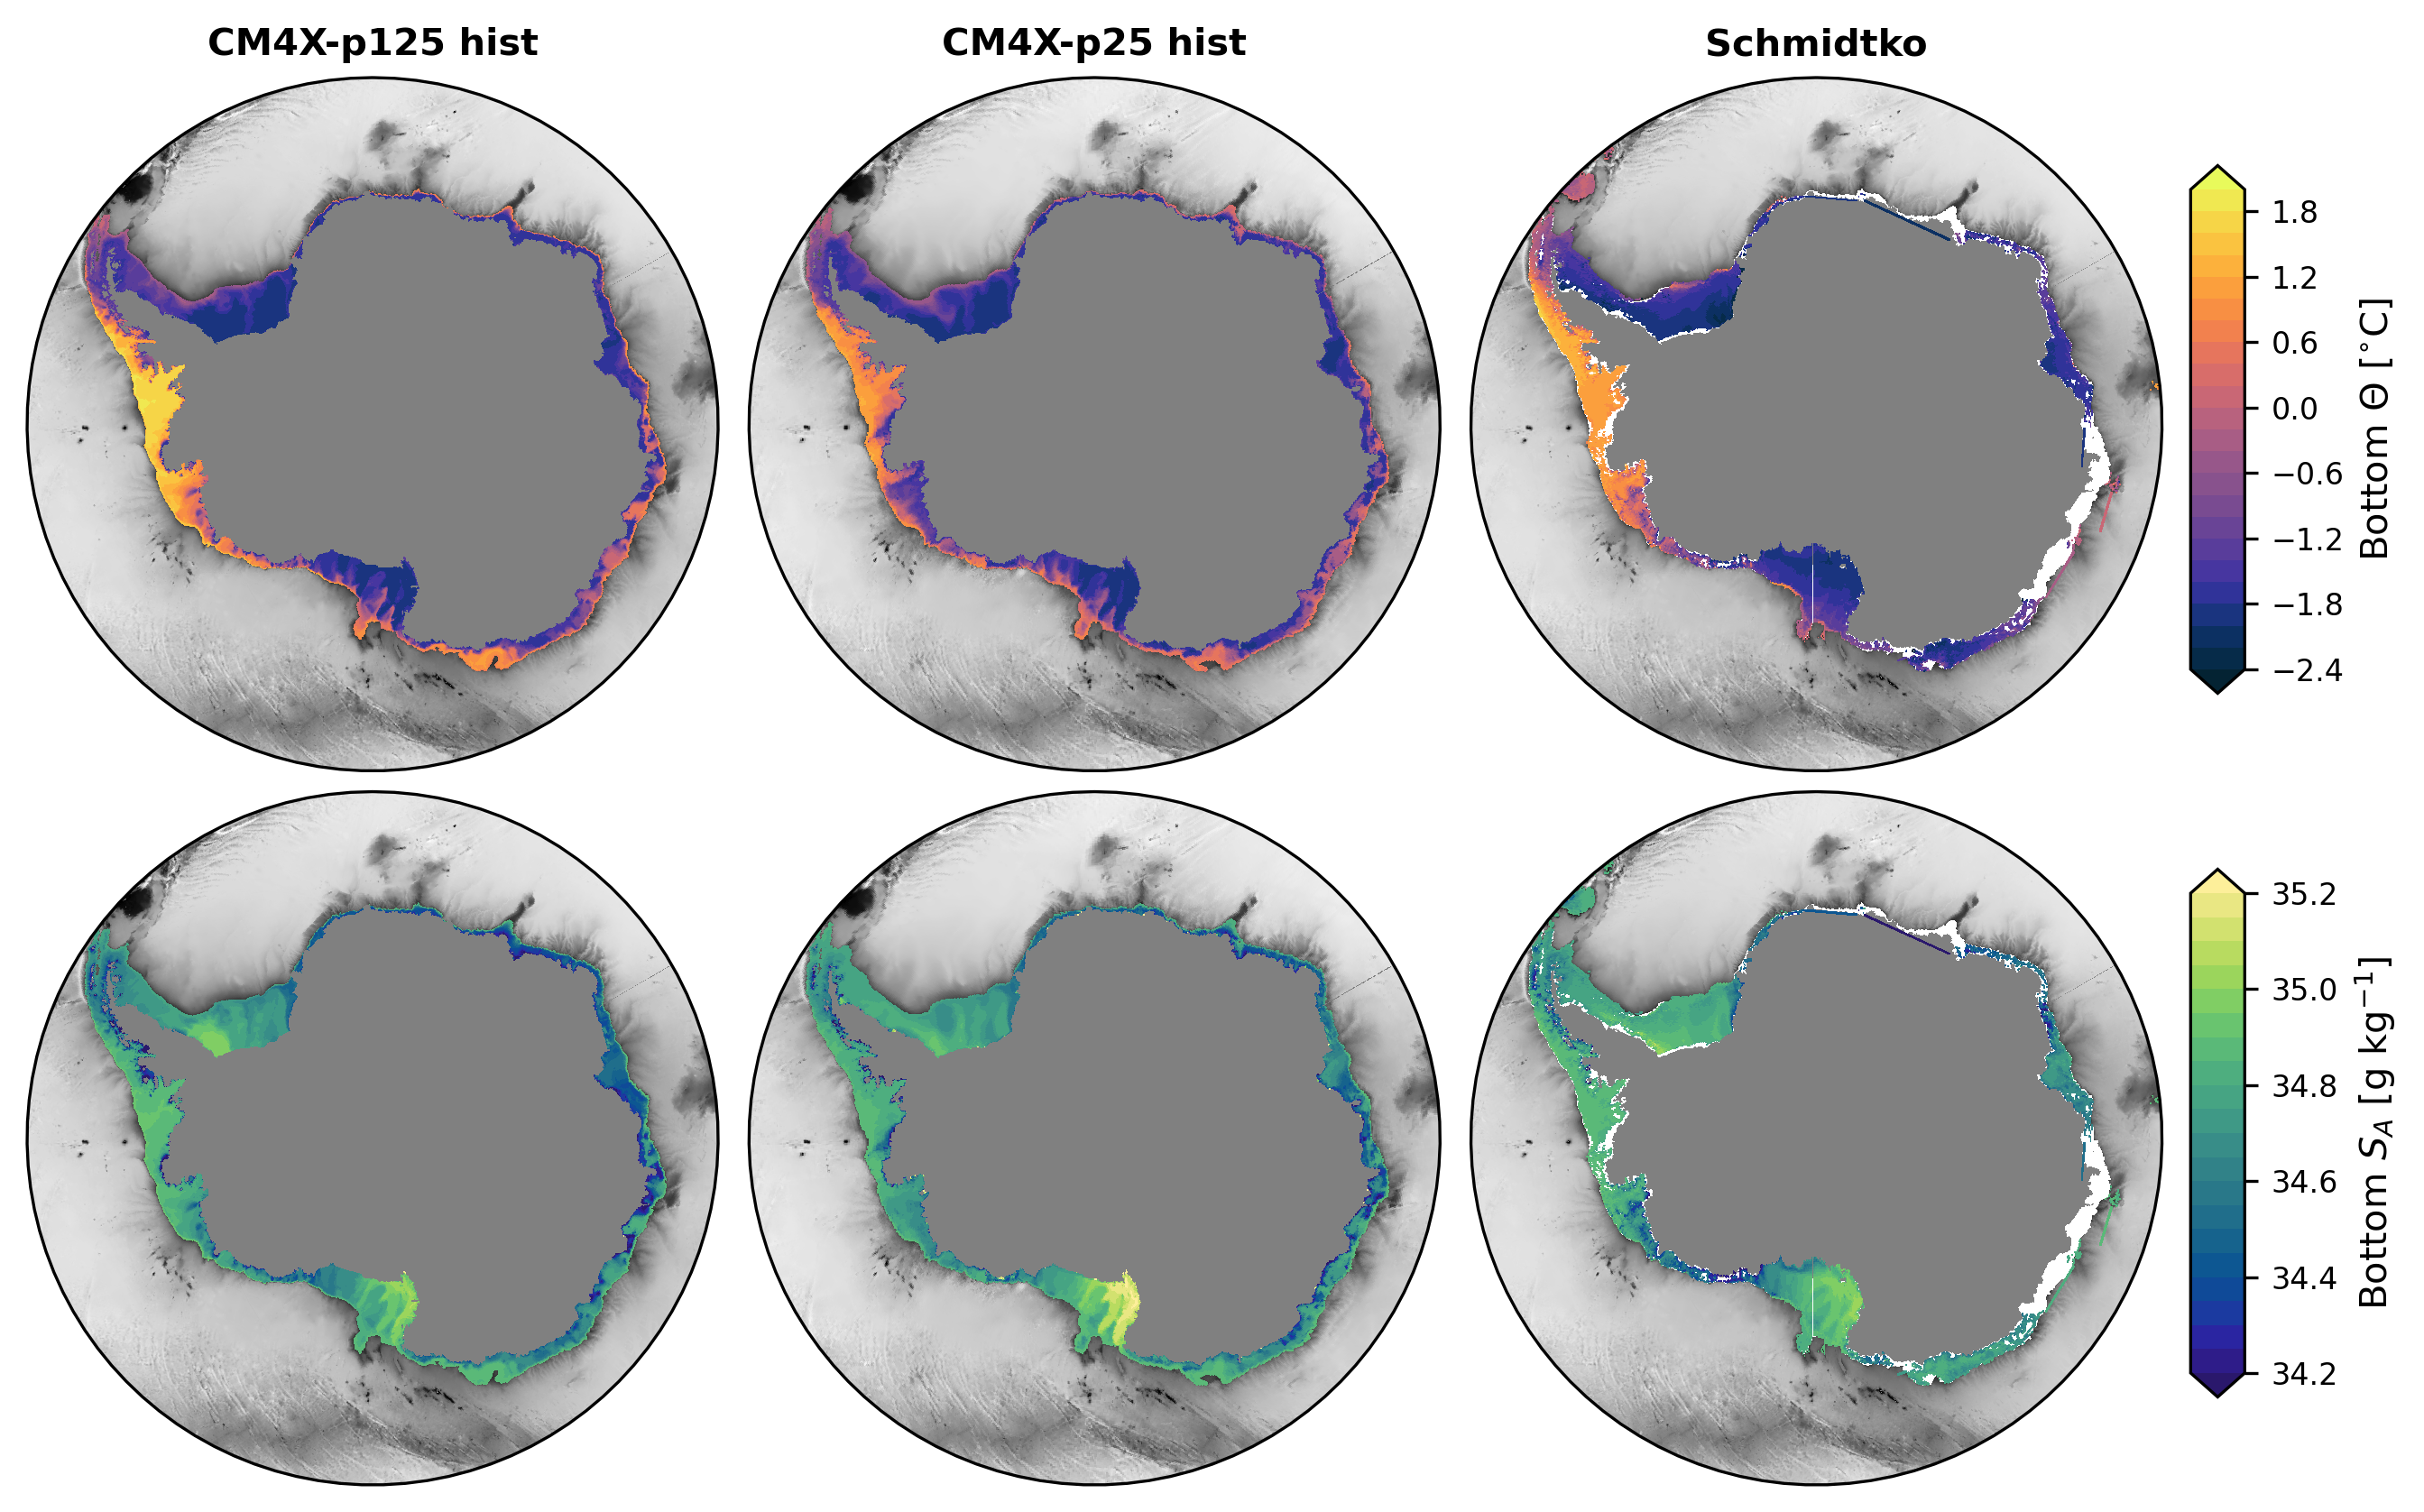

In [13]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10,6.5),
                        subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.03, wspace=0.04)

for i, mod in enumerate(ddictc):
    for j, var in enumerate(list(ddictc[mod])[:2]):
        print(mod,var)
        axs[j,i].set_boundary(circle, transform=axs[j,i].transAxes)
        axs[j,i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
        
        if mod == 'Schmidtko':
            ds = ddictc[mod]
            ds[var+'b'] = ds[var]
        else:
            ds = ddictc[mod][var]
            ds[var+'b'] = ds['bottom_'+var].sel(time=slice(yr_st,yr_ed)).mean('time')
            
        ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})

        #if mod != 'Schmidtko':
        #    continue

        p = ds[var+'b'].where(ds.wet==1).plot(ax=axs[j,i], x='geolon', y='geolat', 
                                              vmin = -2.4 if var=='ct' else 34.2, vmax = 2.0 if var=='ct' else 35.2,
                                              cmap=cmo.thermal if var=='ct' else cmo.haline, 
                                              levels = 23 if var=='ct' else 21, 
                                              add_labels=False, add_colorbar=False, extend='both',
                                              transform=cartopy.crs.PlateCarree(), zorder=2)
        if mod == 'Schmidtko':
            ds = ddictc['CM4Xp125'][var]
            ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})
            
            ds.shlf_mask.where((ds.wet==1)&(ds.shlf_mask==1)).plot(ax=axs[j,i], x='geolon', y='geolat', 
                                                                   add_labels=False, add_colorbar=False, 
                                                                   cmap='Greys_r', vmin=0, vmax=1,
                                                                   transform=cartopy.crs.PlateCarree(), zorder=0)
            ds.deptho.where(ds.shlf_mask==0).plot(ax=axs[j,i], x='geolon', y='geolat', cmap='Greys_r', add_labels=False, 
                                                  add_colorbar=False, transform=cartopy.crs.PlateCarree(), zorder=1)
        else:
            ds.deptho.plot(ax=axs[j,i], x='geolon', y='geolat', cmap='Greys_r',add_labels=False, 
                           add_colorbar=False, transform=cartopy.crs.PlateCarree(),zorder=0)
        
        #ds.shlf_mask.plot.contour(ax=axs[j,i], x='geolon', y='geolat', levels=[1000.0],linewidths=0.5, colors='k', 
        #                          transform=cartopy.crs.PlateCarree(),zorder=3)
        
        if j == 0:
            axs[j,i].set_title(titstr[i], fontsize=10, fontweight='bold')
            
        if i == 2:
            if var == 'ct':
                cax = fig.add_axes([0.90, 0.55 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-2.4,2.0,0.6))
                cb.set_label(r'Bottom $\Theta$ [$^{\circ}$C]', fontsize=10)
                cb.ax.tick_params(labelsize=8)
            else:
                cax = fig.add_axes([0.90, 0.15 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(34.2,35.4,0.2))
                cb.set_label(r'Bottom $S_{A}$ [g kg$^{-1}$]',fontsize=10)
                cb.ax.tick_params(labelsize=8)

plt.savefig('/work/jet/figure.png', dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

CM4Xp125 ct
CM4Xp125 sa
CM4Xp25 ct
CM4Xp25 sa
Schmidtko ct
Schmidtko sa


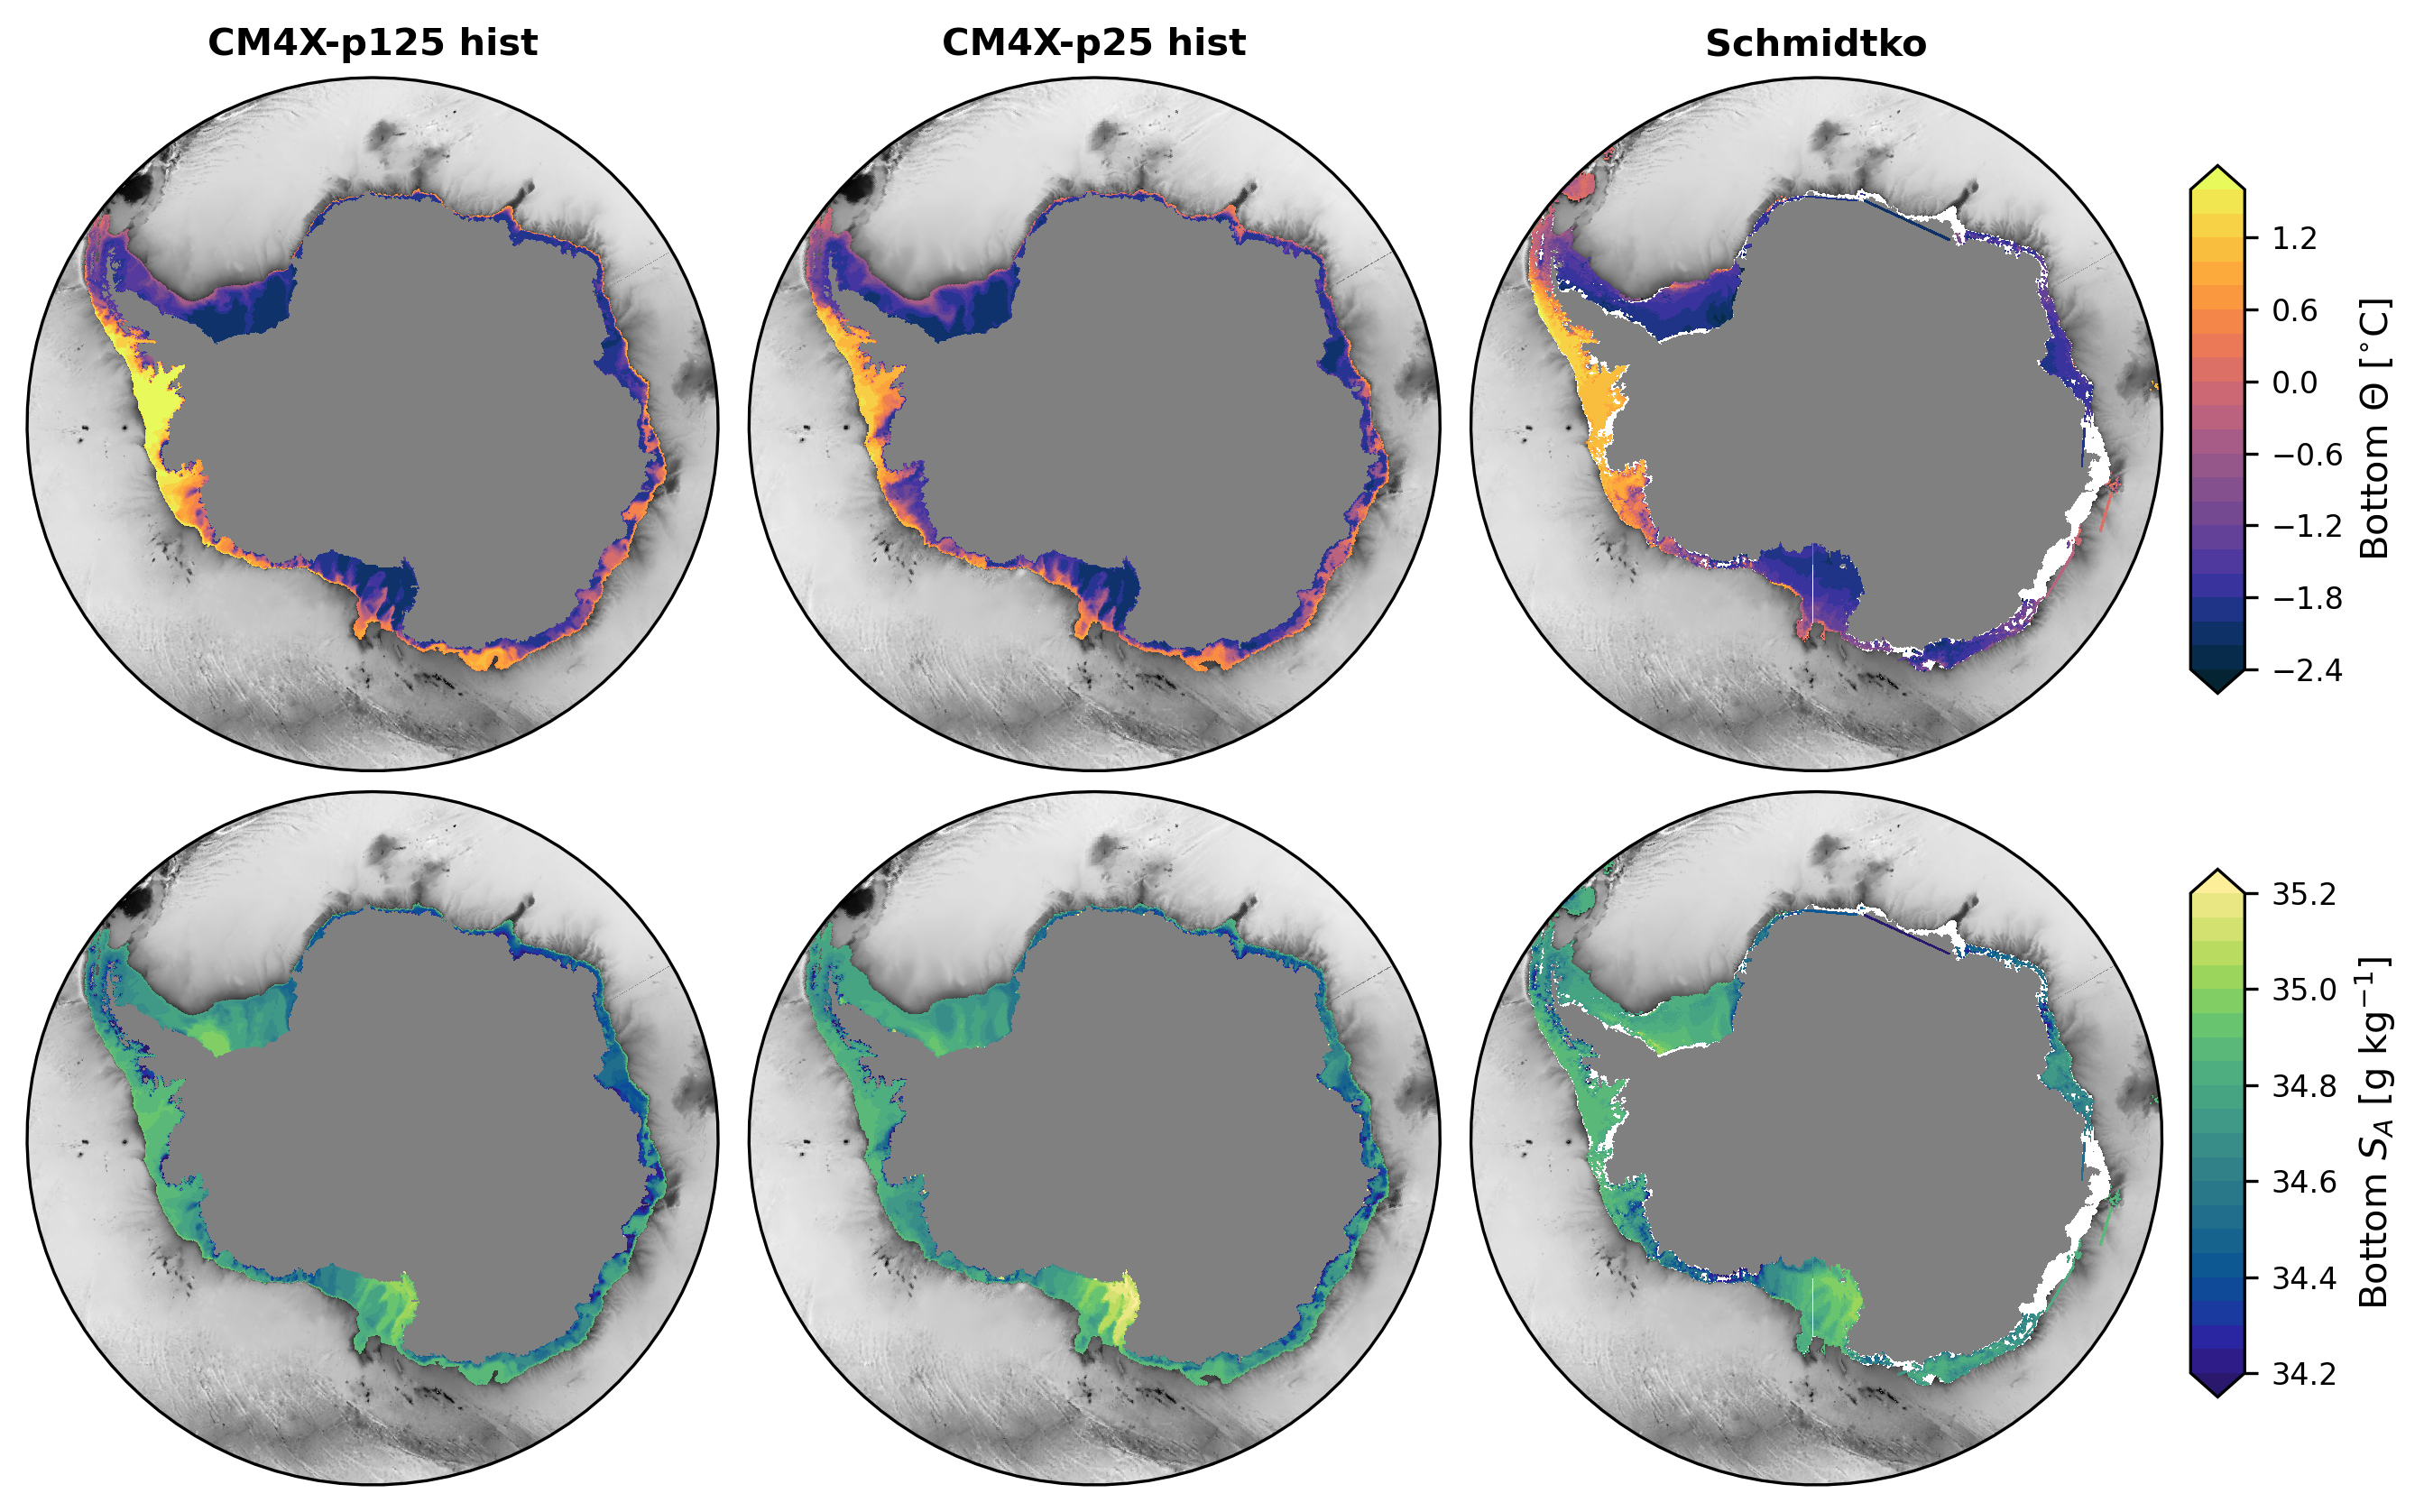

In [60]:
ddictc['CM4Xp125']['ct']['bottom_ct'].time

<xarray.DataArray 'time' (time: 250)>
array([cftime.DatetimeNoLeap(1850, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1851, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1852, 7, 2, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2097, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2098, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 7, 2, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-07-02 12:00:00 ... 2099-07-02 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds
    cell_methods:   time: mean

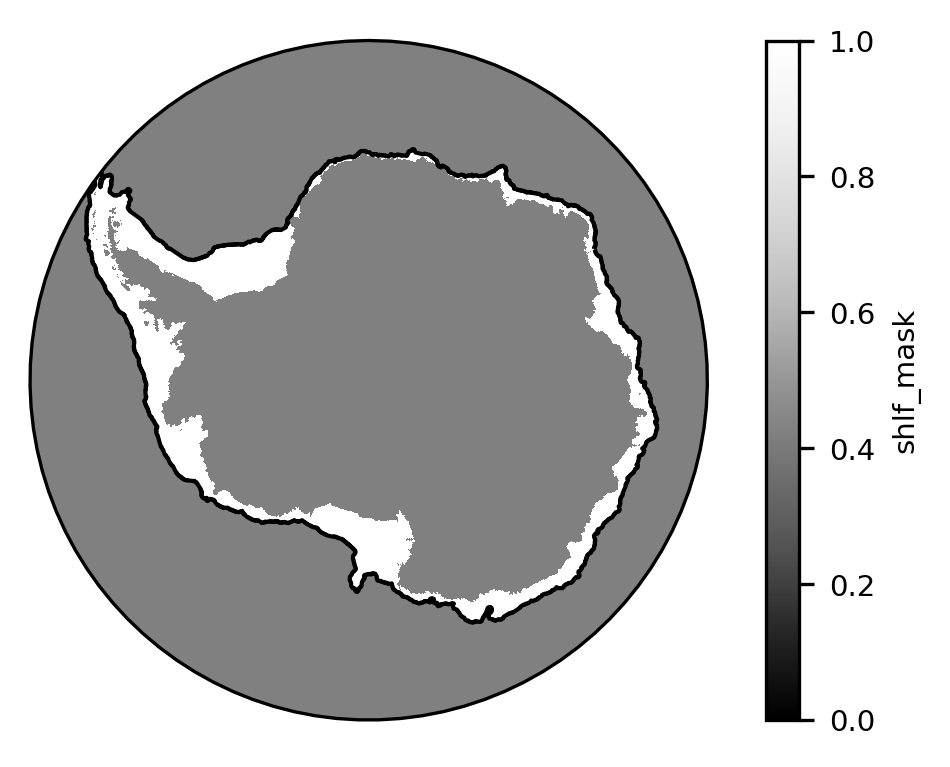

In [55]:
fig = plt.figure(figsize=(5, 3))
ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
p = ds.shlf_mask.where((ds.wet==1)&(ds.shlf_mask==1)).plot(ax=ax, x='geolon', y='geolat', cmap='Greys_r', vmin=0, vmax=1,
                                                           transform=cartopy.crs.PlateCarree(), zorder=0)
ds.shlf_mask.plot.contour(ax=ax, x='geolon', y='geolat', levels=[1000.0],linewidths=1, colors='k', 
                          transform=cartopy.crs.PlateCarree(),zorder=1)
plt.show()

## Anomalies

In [6]:
# New dictionary for concatenated datasets
ddictc = {}
for mod in ddict:
    ddictc[mod] = {}
    for var in variables:
        ddictc[mod][var] = concatenate_datasets(ddict[mod]['historical'][var], ddict[mod]['ssp585'][var])

In [80]:
yr_sta, yr_eda = '1975', '2012' # 38 years
yr_stb, yr_edb = '2062', '2099' # 38 years

In [103]:
ddict_diff = {}
for mod in ['CM4Xp125','CM4Xp25']:
    ddict_diff[mod] = {}
    for var in variables:
        print(mod, var)
        
        # Extract static variables
        static_vars = [v for v in ddictc[mod][var].data_vars if 'time' not in ddictc[mod][var][v].dims]
        ds = ddictc[mod][var][static_vars]
        
        # Calculate difference
        da_meana = ddictc[mod][var]['bottom_'+var].sel(time=slice(yr_sta,yr_eda)).mean('time')
        da_meanb = ddictc[mod][var]['bottom_'+var].sel(time=slice(yr_stb, yr_edb)).mean('time')
        ds[var+'_diff'] = da_meanb - da_meana
        
        # Save to dictionary
        ddict_diff[mod][var] = ds

CM4Xp125 ct
CM4Xp125 sa
CM4Xp25 ct
CM4Xp25 sa


CM4Xp125 ct
CM4Xp125 sa
CM4Xp25 ct
CM4Xp25 sa


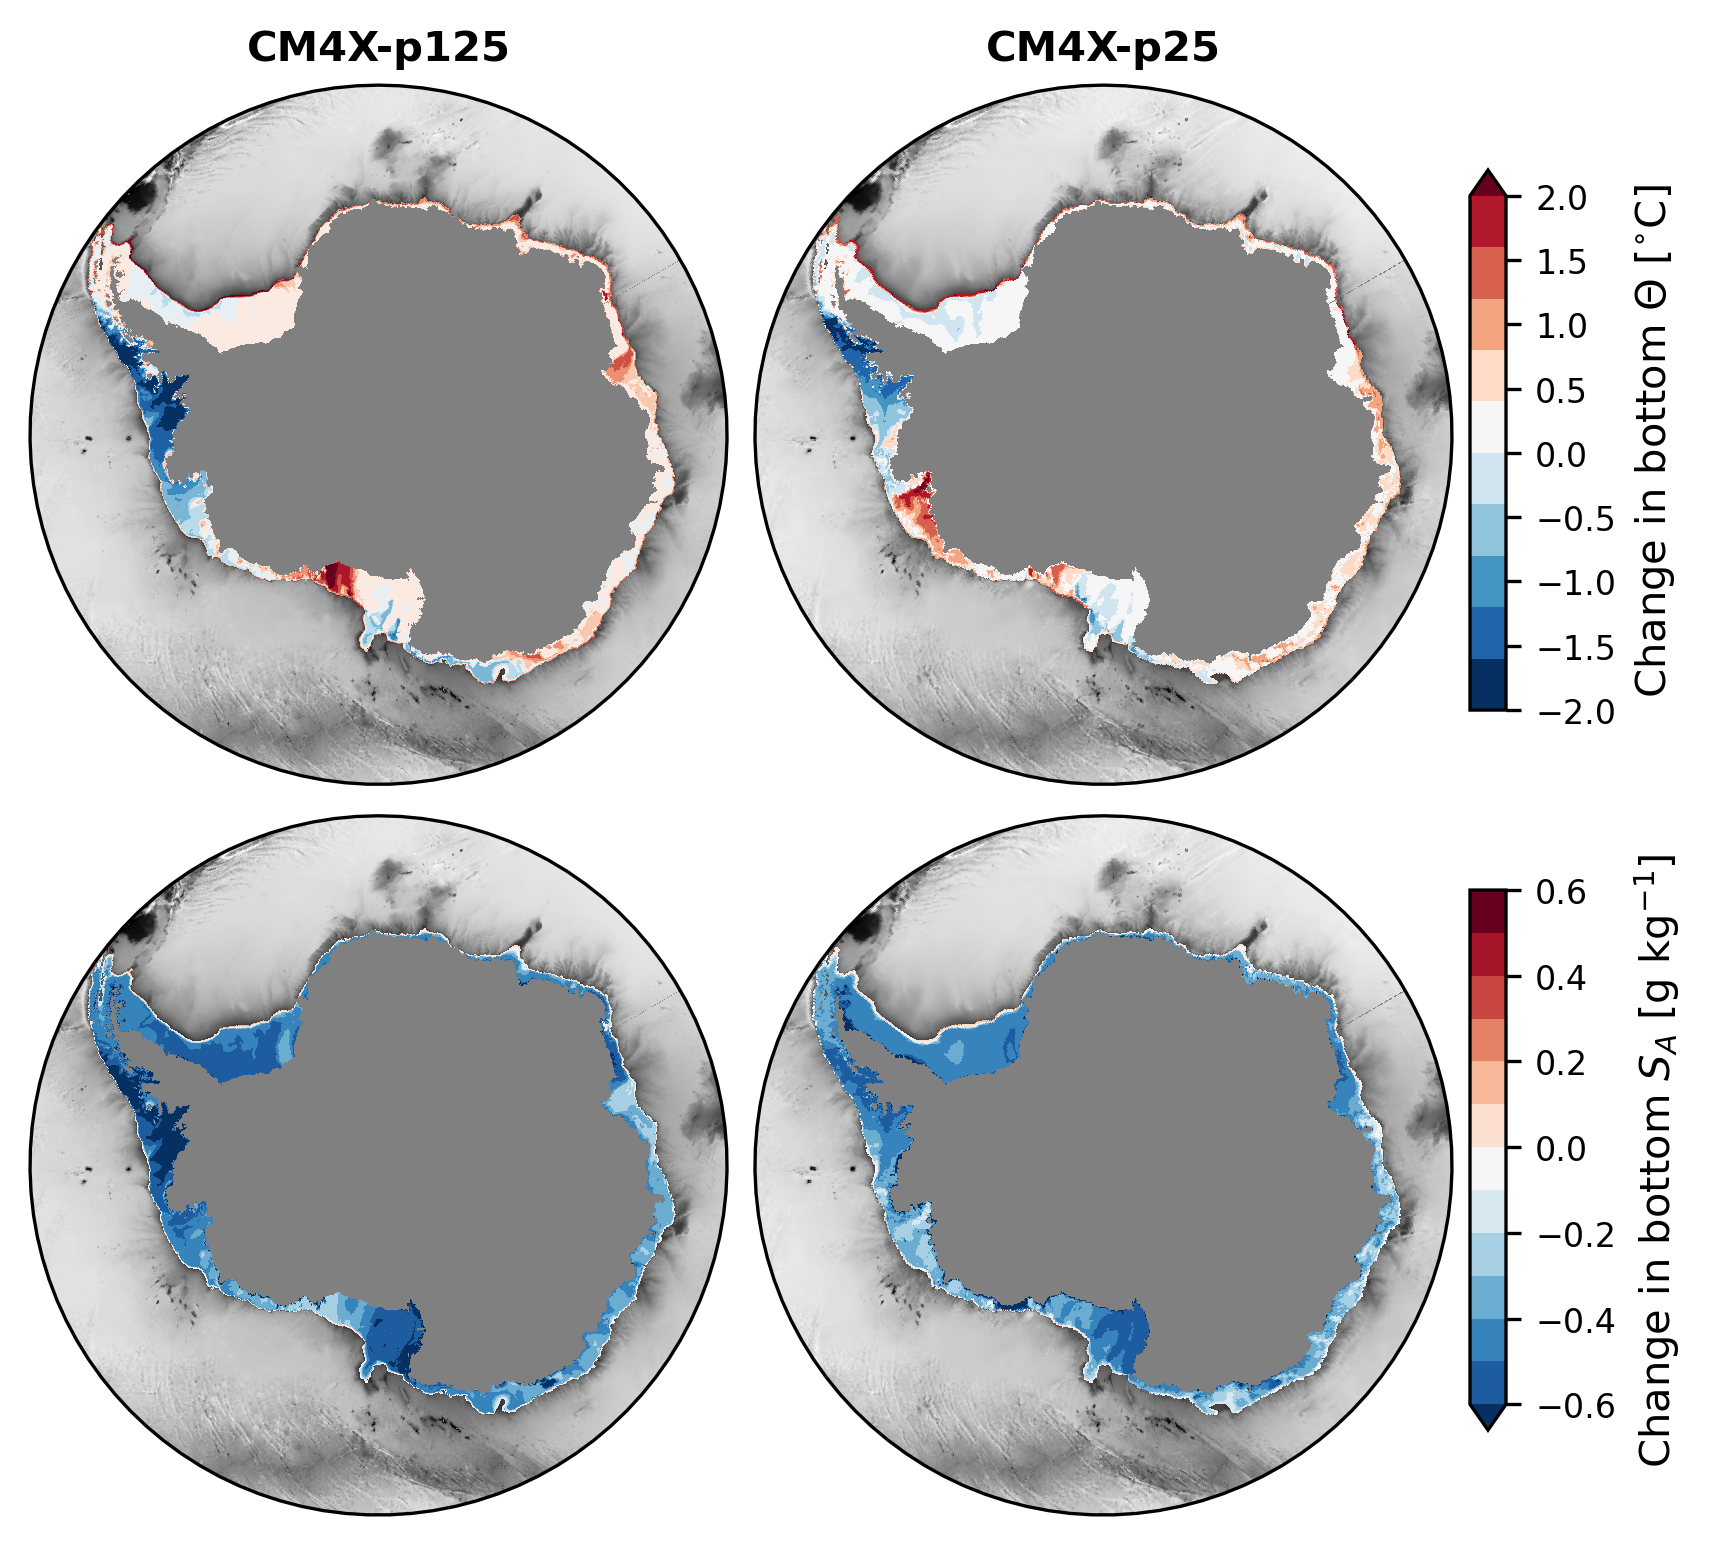

In [127]:
titstr = ['CM4X-p125', 'CM4X-p25']
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(6,6),
                        subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.03, wspace=0.04)

for i, mod in enumerate(ddict_diff):
    for j, var in enumerate(list(ddict_diff[mod])[:2]):
        print(mod,var)
        ds = ddict_diff[mod][var]
        ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})
        
        axs[j,i].set_boundary(circle, transform=axs[j,i].transAxes)
        axs[j,i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
        ds.deptho.plot(ax=axs[j,i], x='geolon', y='geolat', cmap='Greys_r',add_labels=False, 
                       add_colorbar=False, transform=cartopy.crs.PlateCarree(),zorder=0)
        p = ds[var+'_diff'].where(ds.wet==1).plot(ax=axs[j,i], x='geolon', y='geolat', cmap='RdBu_r', 
                                                  vmin = -2 if var=='ct' else -0.6,
                                                  vmax = 2 if var=='ct' else 0.6, levels= 11 if var=='ct' else 13, 
                                                  add_labels=False, add_colorbar=False, 
                                                  transform=cartopy.crs.PlateCarree(), zorder=1)
        
        if j == 0:
            axs[j,i].set_title(titstr[i], fontsize=10, fontweight='bold')
            
        if i == 1:
            if var == 'ct':
                cax = fig.add_axes([0.90, 0.55 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-2,2.5,0.5))
                cb.set_label(r'Change in bottom $\Theta$ [$^{\circ}$C]', fontsize=10)
                cb.ax.tick_params(labelsize=8)
            else:
                cax = fig.add_axes([0.90, 0.15 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-0.6,0.8,0.2))
                cb.set_label(r'Change in bottom $S_{A}$ [g kg$^{-1}$]',fontsize=10)
                cb.ax.tick_params(labelsize=8)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

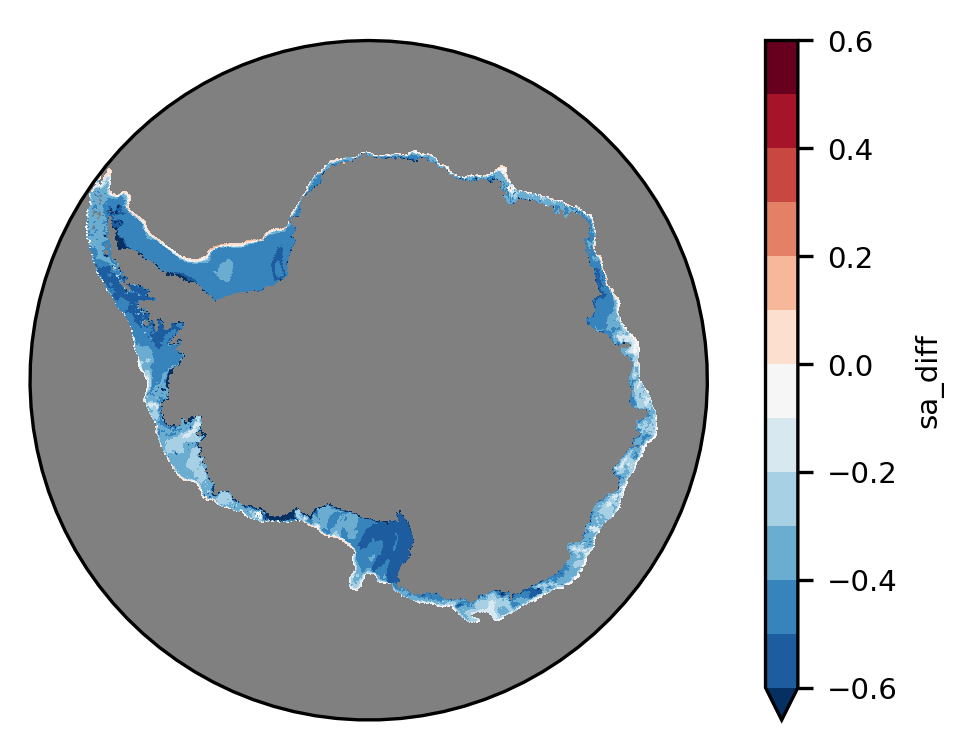

In [123]:
var = 'sa'
ds = ddict_diff[mod][var]
ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})

fig = plt.figure(figsize=(5, 3))
ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
p = ds[var+'_diff'].where(ds.wet==1).plot(ax=ax, x='geolon', y='geolat', cmap='RdBu_r',
                                          vmin = -2 if var=='ct' else -0.6,
                                          vmax = 2 if var=='ct' else 0.6, levels= 17 if var=='ct' else 13, 
                                          transform=cartopy.crs.PlateCarree())
plt.show()

## Difference from piControl

In [9]:
yr_sta, yr_eda = '0101', '0150' # 50 years
yr_stb, yr_edb = '2062', '2099' # 38 years

In [11]:
ddict_diff = {}
for mod in ['CM4Xp125','CM4Xp25']:
    ddict_diff[mod] = {}
    for var in variables:
        print(mod, var)
        
        # Extract static variables
        static_vars = [v for v in ddictc[mod][var].data_vars if 'time' not in ddictc[mod][var][v].dims]
        ds = ddictc[mod][var][static_vars]
        
        # Calculate difference
        da_meana = ddict[mod]['piControl'][var]['bottom_'+var].sel(time=slice(yr_sta,yr_eda)).mean('time')
        da_meanb = ddictc[mod][var]['bottom_'+var].sel(time=slice(yr_stb, yr_edb)).mean('time')
        ds[var+'_diff'] = da_meanb - da_meana
        
        # Save to dictionary
        ddict_diff[mod][var] = ds

CM4Xp125 ct
CM4Xp125 sa
CM4Xp25 ct
CM4Xp25 sa


CM4Xp125 ct
CM4Xp125 sa
CM4Xp25 ct
CM4Xp25 sa


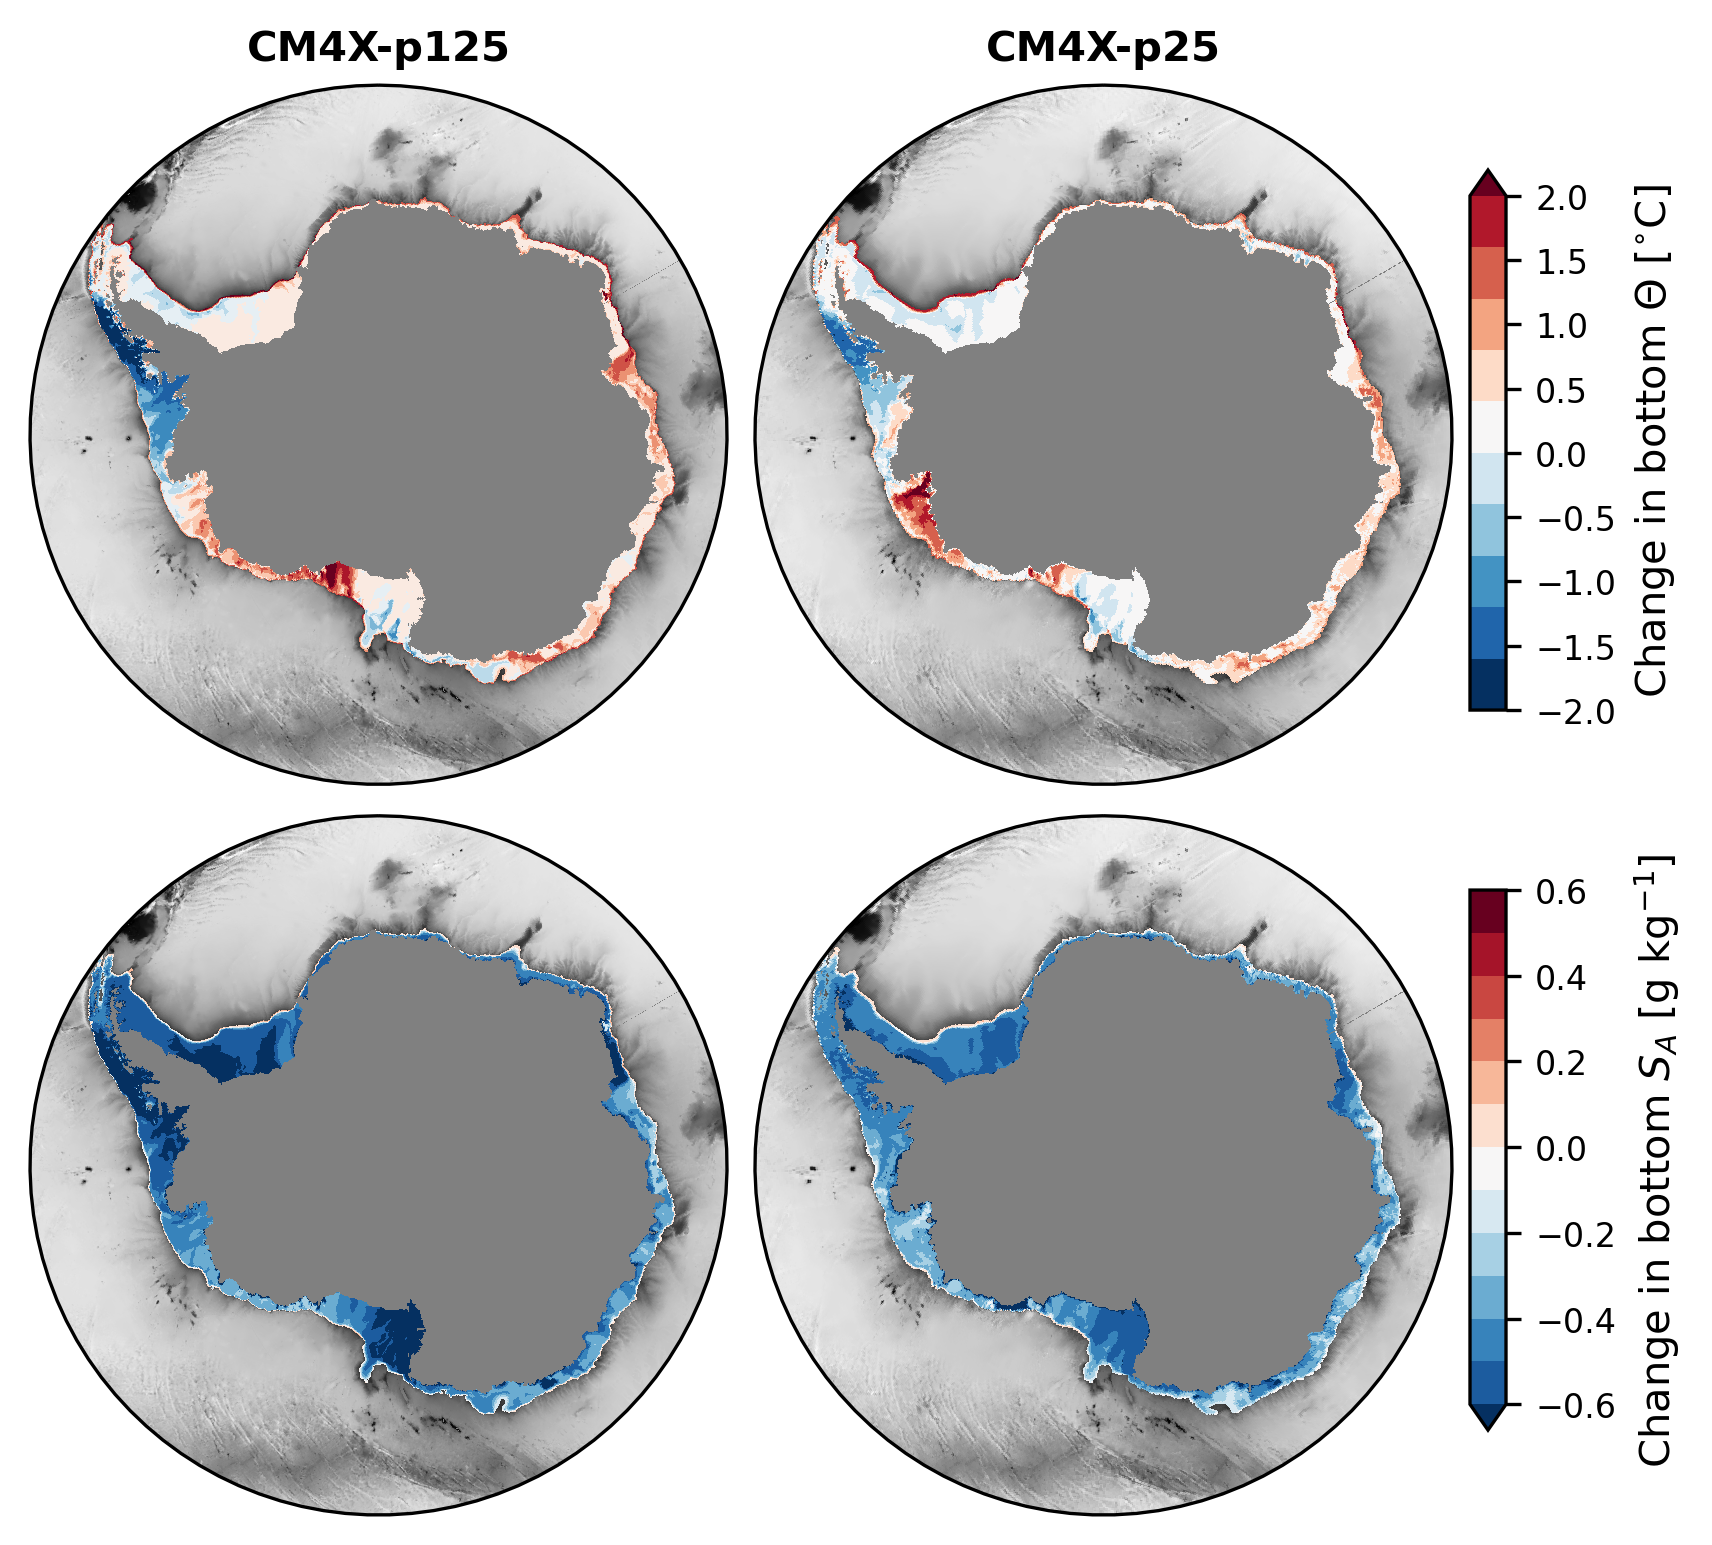

In [15]:
titstr = ['CM4X-p125', 'CM4X-p25']
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(6,6),
                        subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.03, wspace=0.04)

for i, mod in enumerate(ddict_diff):
    for j, var in enumerate(list(ddict_diff[mod])[:2]):
        print(mod,var)
        ds = ddict_diff[mod][var]
        ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})
        
        axs[j,i].set_boundary(circle, transform=axs[j,i].transAxes)
        axs[j,i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
        ds.deptho.plot(ax=axs[j,i], x='geolon', y='geolat', cmap='Greys_r',add_labels=False, 
                       add_colorbar=False, transform=cartopy.crs.PlateCarree(),zorder=0)
        p = ds[var+'_diff'].where(ds.wet==1).plot(ax=axs[j,i], x='geolon', y='geolat', cmap='RdBu_r', 
                                                  vmin = -2 if var=='ct' else -0.6,
                                                  vmax = 2 if var=='ct' else 0.6, levels= 11 if var=='ct' else 13, 
                                                  add_labels=False, add_colorbar=False, 
                                                  transform=cartopy.crs.PlateCarree(), zorder=1)
        
        if j == 0:
            axs[j,i].set_title(titstr[i], fontsize=10, fontweight='bold')
            
        if i == 1:
            if var == 'ct':
                cax = fig.add_axes([0.90, 0.55 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-2,2.5,0.5))
                cb.set_label(r'Change in bottom $\Theta$ [$^{\circ}$C]', fontsize=10)
                cb.ax.tick_params(labelsize=8)
            else:
                cax = fig.add_axes([0.90, 0.15 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-0.6,0.8,0.2))
                cb.set_label(r'Change in bottom $S_{A}$ [g kg$^{-1}$]',fontsize=10)
                cb.ax.tick_params(labelsize=8)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()